# Lecture 9

## Entropy and information content

Let us start with a question: Given a sequence of 0's and 1's, how can we check if one is more **uniform** than the other?


In [1]:
xs = [1,0,1,0,1,0,1,0]
ys = [0,0,0,0,0,0,0,0]

In the first sequence we have four 0's and four 1's while the second sequence contains eight 0's. The answer for this pair is clear: the second sequence is more uniform than the first.

How about this pair?

In [6]:
zs = [1,1,1,1,1,1,1,0]
ts = [0,0,0,0,0,0,1,1]

The first sequence seems more uniform than the second this time.

Appeal your intuition: uniformity is related to differences in probabilities. The formal way of measuring how random one sequence is done via the concept of entropy: if $X$ is a random variable defined by a probability distribution $p(X)$ then the amount of information contained in $X$ is measured by the integral:

$$ H(X) = E(-\log_2 p(X)) = \int - \log_2(p(X)) p(X) dX $$

In case $X$ is discrete:

$$ H(X) = \sum_{i=1}^N -\log_2(p(X_i)) p(X_i) $$

Let us calculate the information stored in these sequences:

In [7]:
from collections import Counter
from math import log

def H(x):
    tmp = Counter(x)
    vs = tmp.values()
    N = len(x)
    return sum([-log(v,2)*v/N for v in vs])+log(N,2)

{'xs': H(xs), 'ys': H(ys), 'zs': H(zs), 'ts': H(ts)}

{'xs': 1.0, 'ys': 0.0, 'zs': 0.5435644431995965, 'ts': 0.8112781244591329}

As we suspected, smaller the entropy values higher the uniformity.

However, entropy is not an additive measure. We can split our data, and the sum of entropies of each partition need not be the total entropy we started with.

Let us do one example by hand.

In [8]:
import pandas as pd
import numpy as np

Data = pd.DataFrame({
       'Outlook': ['sunny', 'sunny', 'overcast', 'rainy', 'rainy', 'rainy', 
                   'overcast', 'sunny', 'sunny', 'rainy', 'sunny', 'overcast',
                   'overcast', 'rainy'],
       'Temperature': ['hot', 'hot', 'hot', 'mild', 'cool', 'cool', 'cool',
                       'mild', 'cool', 'mild', 'mild', 'mild', 'hot', 'mild'],
       'Humidity': ['high', 'high', 'high', 'high', 'normal', 'normal', 'normal',
                    'high', 'normal', 'normal', 'normal', 'high', 'normal', 'high'],
       'Windy': ['false', 'true', 'false', 'false', 'false', 'true', 'true',
                 'false', 'false', 'false', 'true', 'true', 'false', 'true'],
       'Play': ['no', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'yes', 
                            'yes','yes','yes','no']})

Data

,Outlook,Temperature,Humidity,Windy,Play
0,sunny,hot,high,false,no
1,sunny,hot,high,true,no
2,overcast,hot,high,false,yes
3,rainy,mild,high,false,yes
4,rainy,cool,normal,false,yes
5,rainy,cool,normal,true,no
6,overcast,cool,normal,true,yes
7,sunny,mild,high,false,no
8,sunny,cool,normal,false,yes
9,rainy,mild,normal,false,yes


Each column here has its own entropy:

In [11]:
{x: np.round(H(Data[x]),1) for x in Data.columns}

{'Outlook': 1.6,
 'Temperature': 1.6,
 'Humidity': 1.0,
 'Windy': 1.0,
 'Play': 0.9}

And when we split the response variable according to a feature, we get separate entropies for each partition subset:

In [12]:
def splitByValue(xs,ys):
    zs = np.unique(xs)
    tmp = {z: ys[xs==z] for z in zs}
    return {z: {'counts': dict(Counter(tmp[z])), 
                'entropy': H(tmp[z])} for z in zs}

In [13]:
splitByValue(Data['Outlook'],Data['Play'])

{'overcast': {'counts': {'yes': 4}, 'entropy': 0.0},
 'rainy': {'counts': {'yes': 3, 'no': 2}, 'entropy': 0.9709505944546684},
 'sunny': {'counts': {'no': 3, 'yes': 2}, 'entropy': 0.9709505944546684}}

In [14]:
splitByValue(Data['Temperature'],Data['Play'])

{'cool': {'counts': {'yes': 3, 'no': 1}, 'entropy': 0.8112781244591327},
 'hot': {'counts': {'no': 2, 'yes': 2}, 'entropy': 1.0},
 'mild': {'counts': {'yes': 4, 'no': 2}, 'entropy': 0.9182958340544896}}

In [15]:
splitByValue(Data['Humidity'],Data['Play'])

{'high': {'counts': {'no': 4, 'yes': 3}, 'entropy': 0.9852281360342516},
 'normal': {'counts': {'yes': 6, 'no': 1}, 'entropy': 0.5916727785823275}}

In [16]:
splitByValue(Data['Windy'],Data['Play'])

{'false': {'counts': {'no': 2, 'yes': 6}, 'entropy': 0.8112781244591329},
 'true': {'counts': {'no': 3, 'yes': 3}, 'entropy': 0.9999999999999998}}

In [17]:
splitByValue(Data['Temperature'],Data['Outlook'])

{'cool': {'counts': {'rainy': 2, 'overcast': 1, 'sunny': 1}, 'entropy': 1.5},
 'hot': {'counts': {'sunny': 2, 'overcast': 2}, 'entropy': 1.0},
 'mild': {'counts': {'rainy': 3, 'sunny': 2, 'overcast': 1},
  'entropy': 1.4591479170272446}}

In [ ]:
-log_2(p(X)/q(X))p(X) = -log_2(p(X))p(X) - log_2(q(X))p(X)

## Decision Trees

[Decision Tree](https://en.wikipedia.org/wiki/Decision_tree) algorithm belongs to the class of Supervised Learning algorithm. Thus it applies to a finite collection of data points $(x_i,y_i)\in D$ where $x_i$'s are independent variables and $y_i$'s are dependent (or response) variables. The main idea behind Decision Tree models is to create a partition $D_1,\ldots,D_m$ of $D$ such that on each $D_j$ the response variable $y_i$'s are **almost constant** or **almost uniform**.  

If we look at the partitions above, we see that the most promising feature is `Outlook` and the most promising value is `overcast`

$$argmin_{P} \sum_{i\in P} H(D_i)$$

In [18]:
uniform = Data[Data['Outlook']=='overcast']
rest = Data[Data['Outlook']!='overcast']
uniform

,Outlook,Temperature,Humidity,Windy,Play
2,overcast,hot,high,false,yes
6,overcast,cool,normal,true,yes
11,overcast,mild,high,true,yes
12,overcast,hot,normal,false,yes


In [19]:
rest

,Outlook,Temperature,Humidity,Windy,Play
0,sunny,hot,high,false,no
1,sunny,hot,high,true,no
3,rainy,mild,high,false,yes
4,rainy,cool,normal,false,yes
5,rainy,cool,normal,true,no
7,sunny,mild,high,false,no
8,sunny,cool,normal,false,yes
9,rainy,mild,normal,false,yes
10,sunny,mild,normal,true,yes
13,rainy,mild,high,true,no


In [20]:
splitByValue(rest['Outlook'],rest['Play'])

{'rainy': {'counts': {'yes': 3, 'no': 2}, 'entropy': 0.9709505944546684},
 'sunny': {'counts': {'no': 3, 'yes': 2}, 'entropy': 0.9709505944546684}}

In [21]:
splitByValue(rest['Temperature'],rest['Play'])

{'cool': {'counts': {'yes': 2, 'no': 1}, 'entropy': 0.9182958340544897},
 'hot': {'counts': {'no': 2}, 'entropy': 0.0},
 'mild': {'counts': {'yes': 3, 'no': 2}, 'entropy': 0.9709505944546684}}

In [22]:
splitByValue(rest['Humidity'],rest['Play'])

{'high': {'counts': {'no': 4, 'yes': 1}, 'entropy': 0.7219280948873621},
 'normal': {'counts': {'yes': 4, 'no': 1}, 'entropy': 0.7219280948873621}}

In [23]:
splitByValue(rest['Windy'],rest['Play'])

{'false': {'counts': {'no': 2, 'yes': 4}, 'entropy': 0.9182958340544896},
 'true': {'counts': {'no': 3, 'yes': 1}, 'entropy': 0.8112781244591327}}

The next promising feature is `Humidity` and the most promising value is `high`:

In [26]:
uniform2 = rest[rest['Humidity']=='high']
rest2 = rest[rest['Humidity']!='high']
uniform2

,Outlook,Temperature,Humidity,Windy,Play
0,sunny,hot,high,false,no
1,sunny,hot,high,true,no
3,rainy,mild,high,false,yes
7,sunny,mild,high,false,no
13,rainy,mild,high,true,no


In [27]:
rest2

,Outlook,Temperature,Humidity,Windy,Play
4,rainy,cool,normal,false,yes
5,rainy,cool,normal,true,no
8,sunny,cool,normal,false,yes
9,rainy,mild,normal,false,yes
10,sunny,mild,normal,true,yes


So, here is out decision tree so far:

    if Outlook = overcast
       Play = Yes (prob = 1.0)
    else if Humidy = high 
       Play = No (prob = 0.8)
    else
       Play = Yes (prob = 0.8)
       
But, we don't have to do this by hand. Let us do it via `scikit-learn`

In [33]:
from sklearn.tree import DecisionTreeClassifier

indeps = ['Outlook','Temperature','Humidity','Windy']
classifier = DecisionTreeClassifier(max_depth=2, criterion='entropy')

xs = pd.get_dummies(Data[indeps])
ys = Data['Play']

classifier.fit(xs,ys)

DecisionTreeClassifier(criterion='entropy', max_depth=2)

[Text(446.40000000000003, 453.0, 'Outlook_overcast <= 0.5\nentropy = 0.94\nsamples = 14\nvalue = [5, 9]\nclass = yes'),
 Text(297.6, 271.8, 'Humidity_normal <= 0.5\nentropy = 1.0\nsamples = 10\nvalue = [5, 5]\nclass = no'),
 Text(148.8, 90.59999999999997, 'entropy = 0.722\nsamples = 5\nvalue = [4, 1]\nclass = no'),
 Text(446.40000000000003, 90.59999999999997, 'entropy = 0.722\nsamples = 5\nvalue = [1, 4]\nclass = yes'),
 Text(595.2, 271.8, 'entropy = 0.0\nsamples = 4\nvalue = [0, 4]\nclass = yes')]

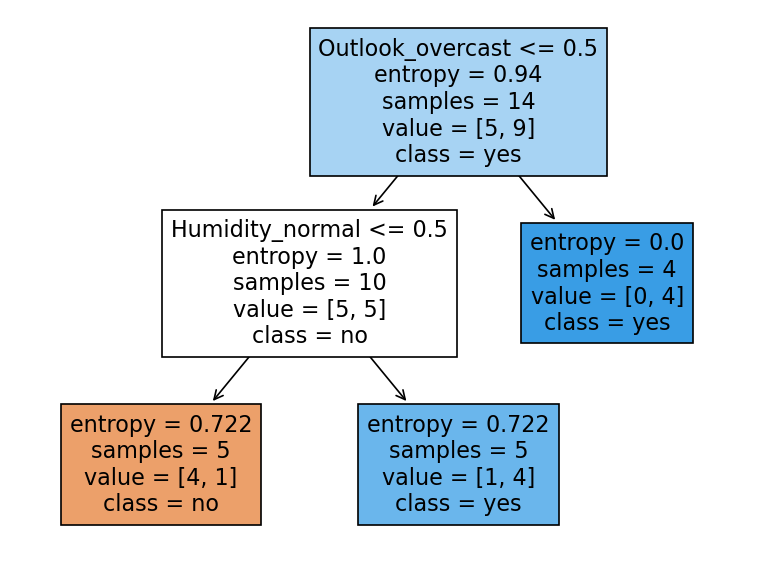

In [34]:
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize=(8, 6), dpi=120)
tree.plot_tree(classifier,
               feature_names=xs.columns,
               class_names=np.unique(Data['Play']),
               filled = True)

### Another example

Let us look at another example:


In [37]:
from sklearn.model_selection import train_test_split

Data2 = pd.read_excel('data/default of credit card clients.xls',header=1)
Data2

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [38]:
ys = Data2['default payment next month']
xs = Data2
del xs['ID'], xs['default payment next month']

xtrain,xtest,ytrain,ytest = train_test_split(xs,ys)

model2 = DecisionTreeClassifier(max_depth=3,criterion='entropy')

model2.fit(xtrain,ytrain)
model2.score(xtest,ytest)

0.8225333333333333

[Text(930.0, 1585.5, 'PAY_0 <= 1.5\nentropy = 0.764\nsamples = 22500\nvalue = [17505, 4995]'),
 Text(465.0, 1132.5, 'PAY_2 <= 1.5\nentropy = 0.649\nsamples = 20144\nvalue = [16794, 3350]'),
 Text(232.5, 679.5, 'PAY_AMT2 <= 1600.5\nentropy = 0.593\nsamples = 18428\nvalue = [15789, 2639]'),
 Text(116.25, 226.5, 'entropy = 0.72\nsamples = 7093\nvalue = [5681, 1412]'),
 Text(348.75, 226.5, 'entropy = 0.495\nsamples = 11335\nvalue = [10108, 1227]'),
 Text(697.5, 679.5, 'PAY_5 <= 1.0\nentropy = 0.979\nsamples = 1716\nvalue = [1005, 711]'),
 Text(581.25, 226.5, 'entropy = 0.953\nsamples = 1196\nvalue = [750, 446]'),
 Text(813.75, 226.5, 'entropy = 1.0\nsamples = 520\nvalue = [255, 265]'),
 Text(1395.0, 1132.5, 'PAY_6 <= 1.0\nentropy = 0.883\nsamples = 2356\nvalue = [711, 1645]'),
 Text(1162.5, 679.5, 'BILL_AMT1 <= 2207.5\nentropy = 0.936\nsamples = 1394\nvalue = [491, 903]'),
 Text(1046.25, 226.5, 'entropy = 0.972\nsamples = 132\nvalue = [79, 53]'),
 Text(1278.75, 226.5, 'entropy = 0.911\nsam

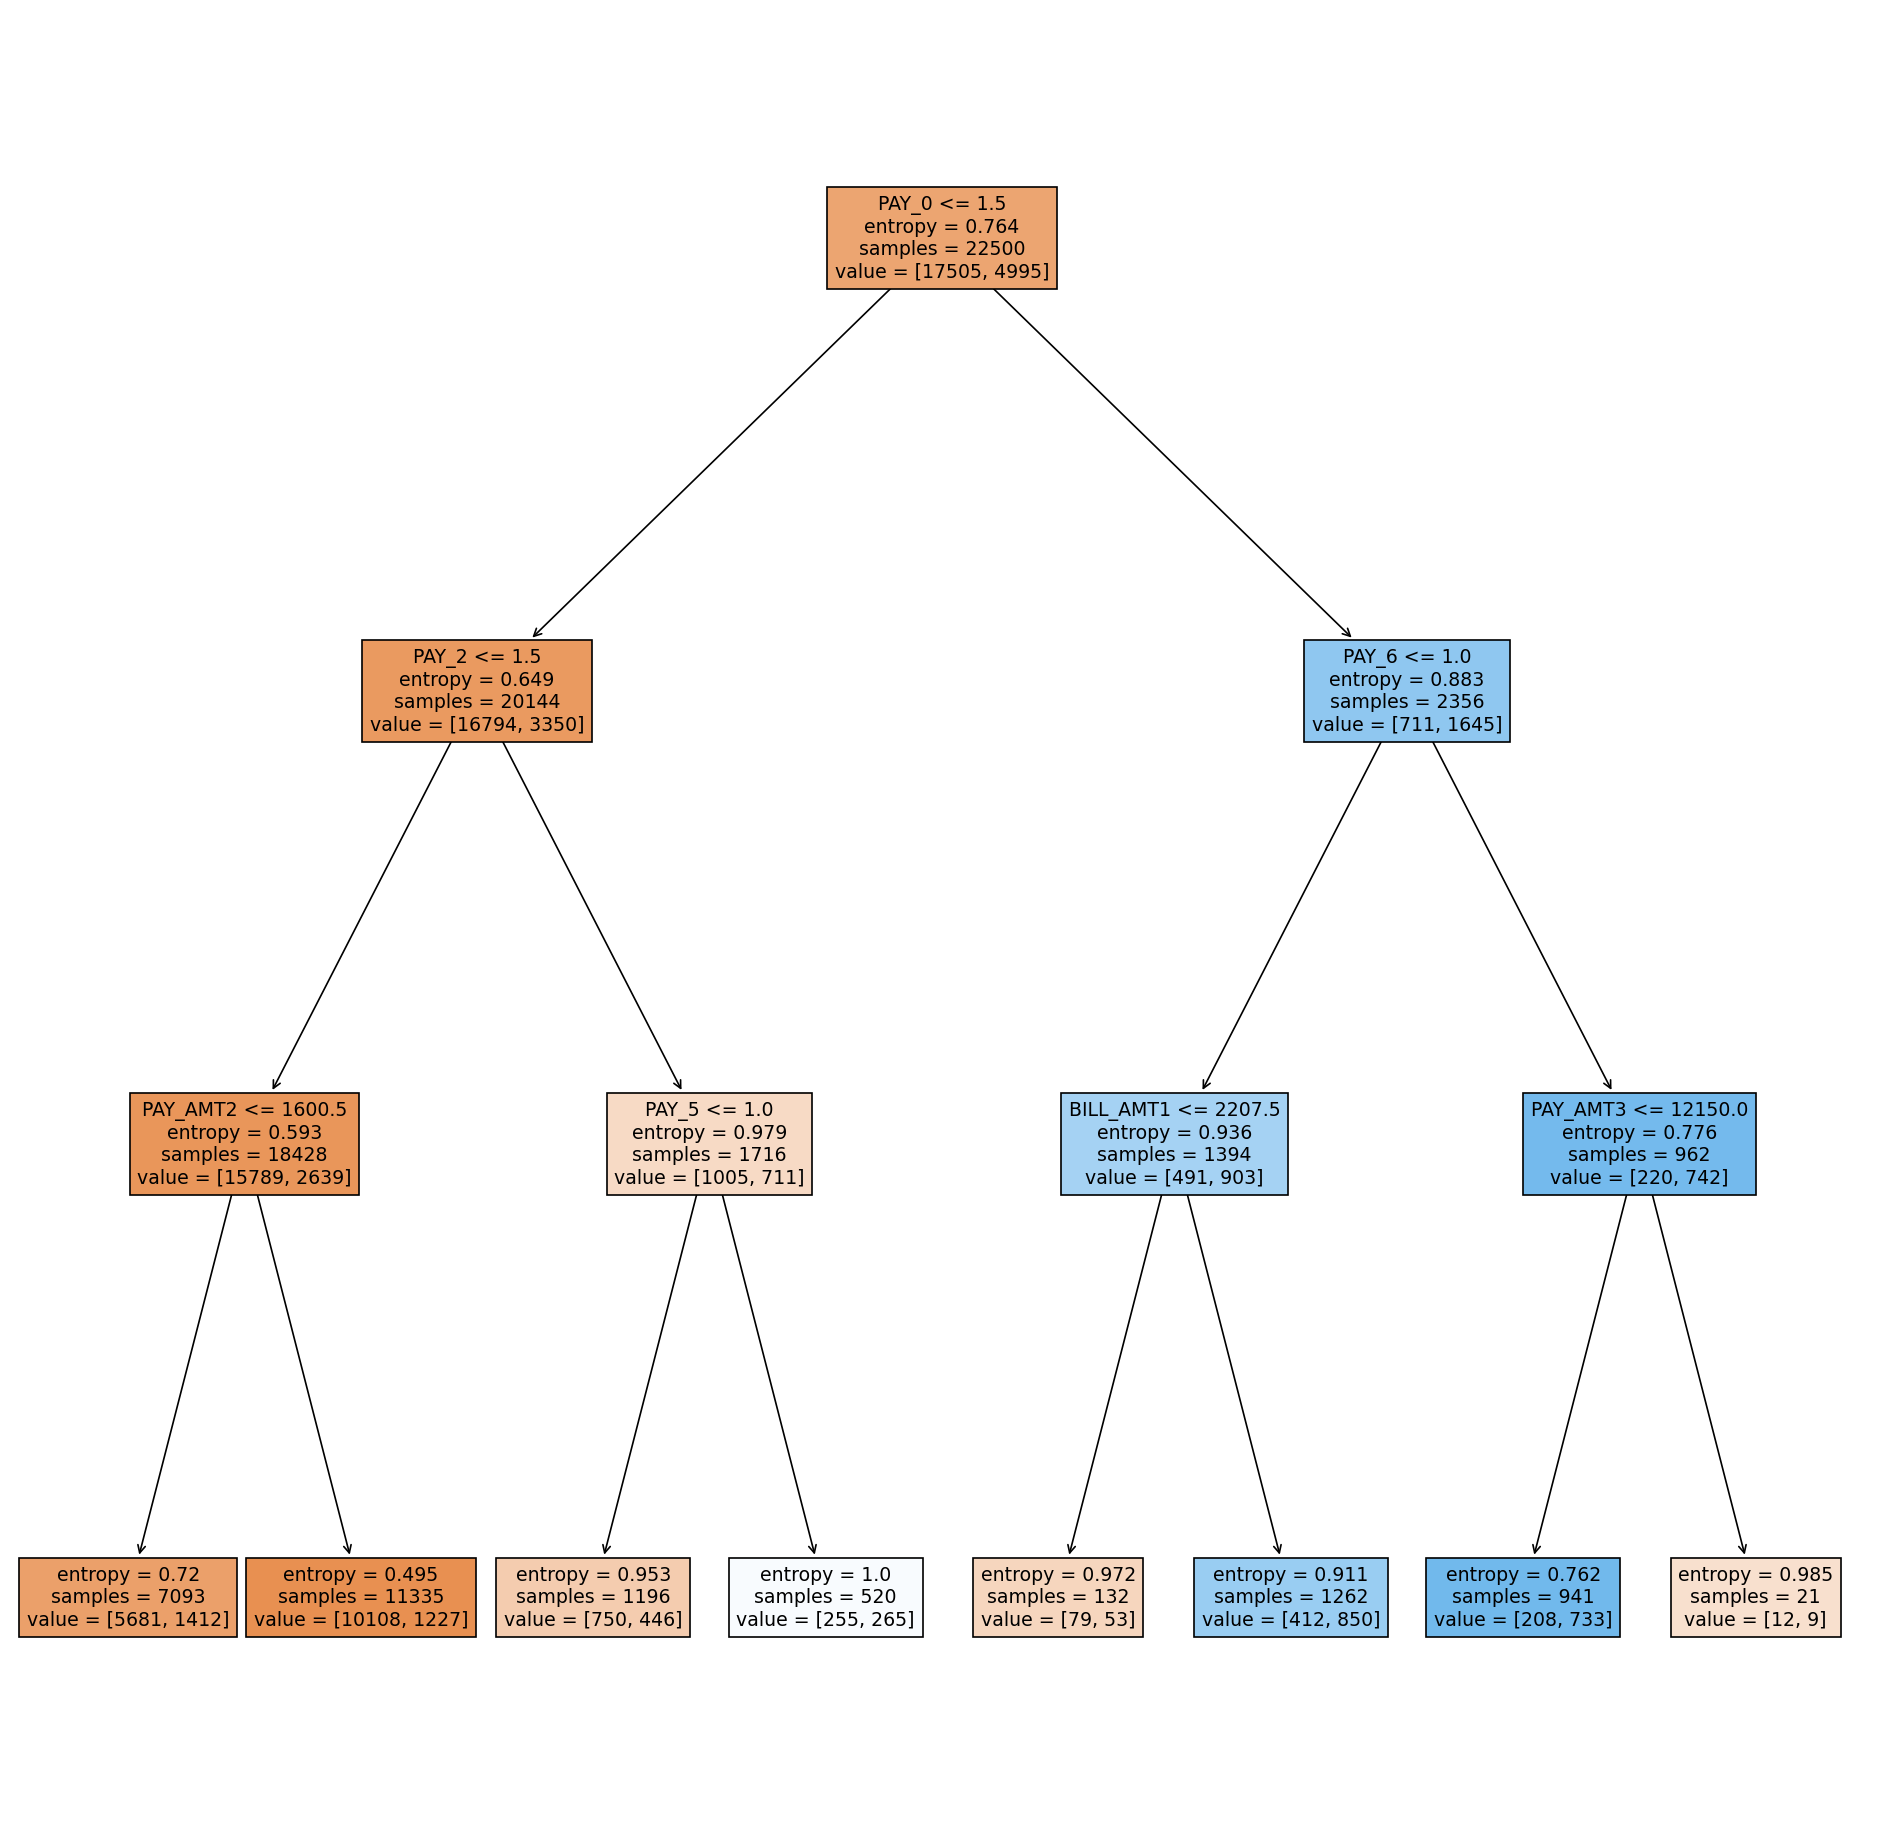

In [39]:
plt.figure(figsize=(20,20), dpi=120)
tree.plot_tree(model2,
               feature_names=xtrain.columns,
               filled = True)

In [44]:
from scipy.stats import t

def doExperiment(xs,ys,model,ts=0.2):
    xtrain,xtest,ytrain,ytest = train_test_split(xs,ys,test_size=ts)
    model.fit(xtrain,ytrain)
    return model.score(xtest,ytest)

In [47]:
N = 5
experiments = np.array([doExperiment(xs,ys,DecisionTreeClassifier(criterion='entropy')) for i in range(N)])
t.interval(0.95,N-1,loc=experiments.mean(),scale=experiments.var())

(0.7313643972863103, 0.7315022693803565)

In [51]:
from sklearn.datasets import load_breast_cancer

Data3 = load_breast_cancer()
pd.DataFrame(Data3['data'])

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [56]:
xs = Data3['data']
ys = Data3['target']

xtrain,xtest,ytrain,ytest = train_test_split(xs,ys)

model3 = DecisionTreeClassifier(max_depth=3,criterion='gini')

model3.fit(xtrain,ytrain)
model3.score(xtest,ytest)

0.8671328671328671

[Text(1860.0, 3171.0, 'X[23] <= 884.55\ngini = 0.46\nsamples = 426\nvalue = [153, 273]'),
 Text(930.0, 2265.0, 'X[27] <= 0.163\ngini = 0.13\nsamples = 286\nvalue = [20, 266]'),
 Text(465.0, 1359.0, 'X[27] <= 0.132\ngini = 0.05\nsamples = 271\nvalue = [7, 264]'),
 Text(232.5, 453.0, 'gini = 0.016\nsamples = 248\nvalue = [2, 246]'),
 Text(697.5, 453.0, 'gini = 0.34\nsamples = 23\nvalue = [5, 18]'),
 Text(1395.0, 1359.0, 'X[23] <= 660.45\ngini = 0.231\nsamples = 15\nvalue = [13, 2]'),
 Text(1162.5, 453.0, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(1627.5, 453.0, 'gini = 0.0\nsamples = 13\nvalue = [13, 0]'),
 Text(2790.0, 2265.0, 'X[26] <= 0.201\ngini = 0.095\nsamples = 140\nvalue = [133, 7]'),
 Text(2325.0, 1359.0, 'X[27] <= 0.083\ngini = 0.408\nsamples = 7\nvalue = [2, 5]'),
 Text(2092.5, 453.0, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(2557.5, 453.0, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(3255.0, 1359.0, 'X[5] <= 0.063\ngini = 0.03\nsamples = 133\nvalue = [131,

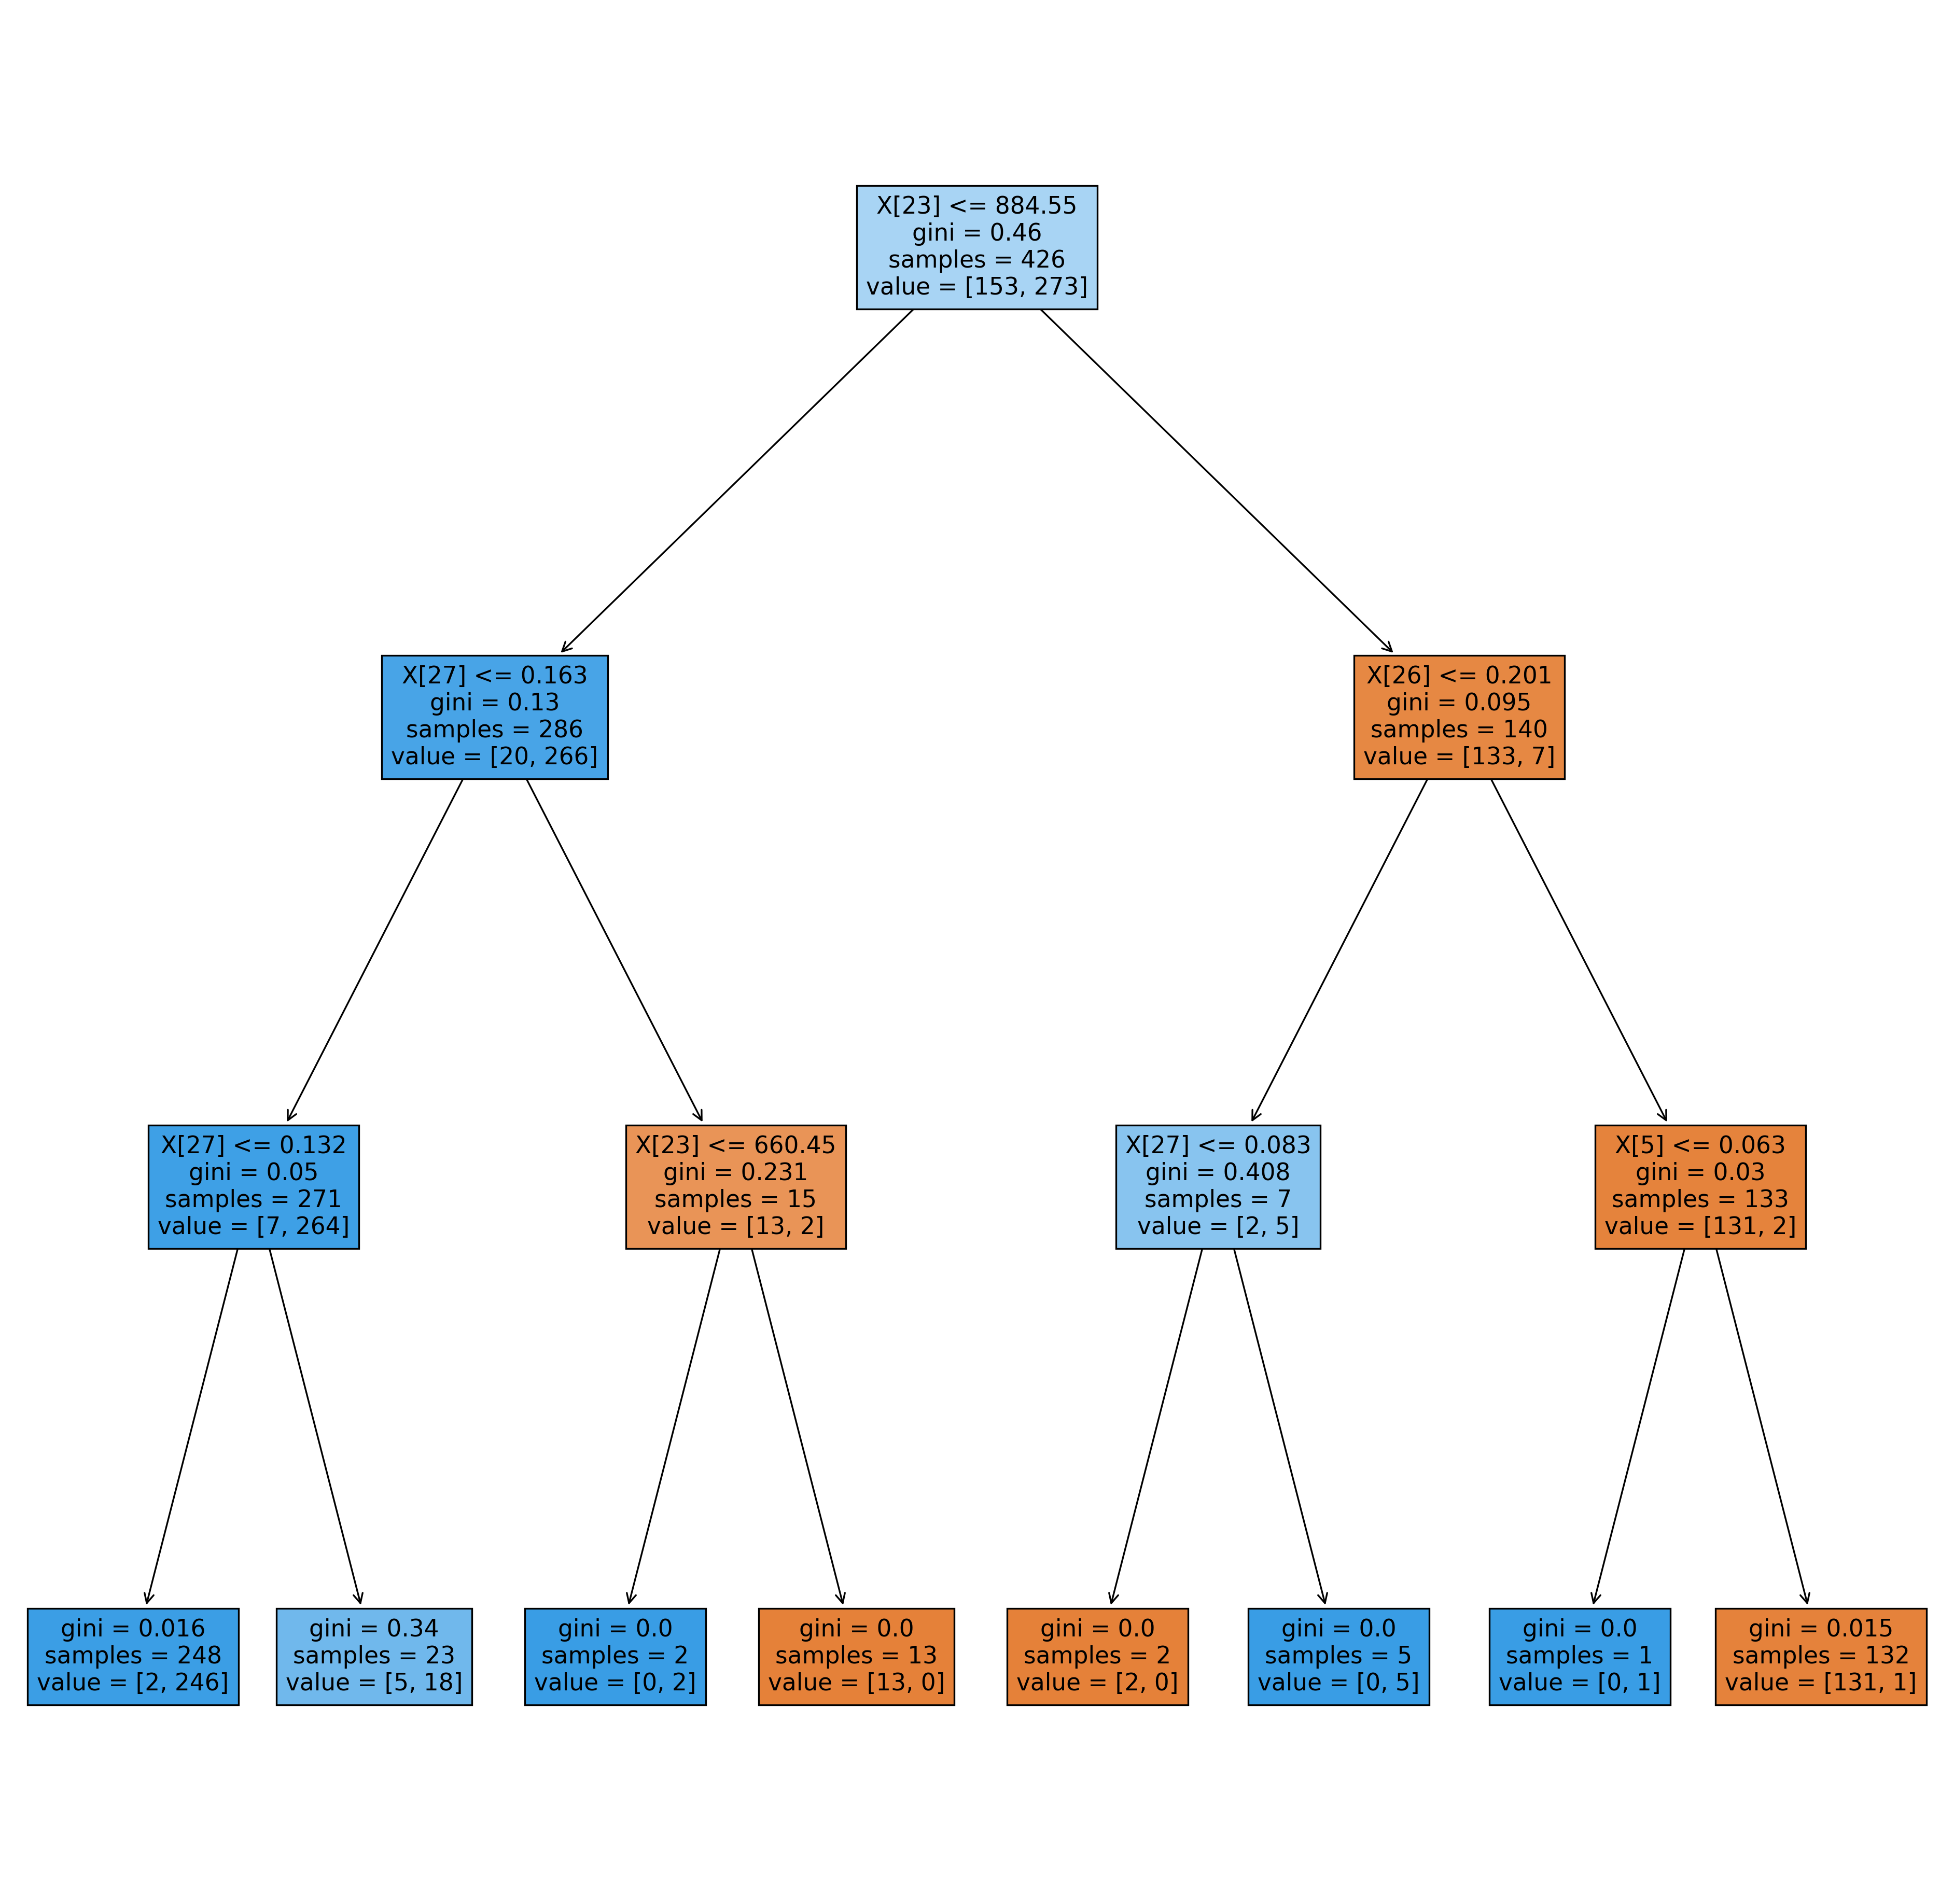

In [57]:
plt.figure(figsize=(20,20), dpi=240)
tree.plot_tree(model3,
               filled = True)

In [58]:
N = 5
experiments = np.array([doExperiment(xs,ys,DecisionTreeClassifier(max_depth=3,criterion='gini')) for i in range(N)])
t.interval(0.95,N-1,loc=experiments.mean(),scale=experiments.var())

(0.9364601068750402, 0.9407328755811002)

## Decision tree regression

One can use decision trees as regression models:

In [74]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_boston

Data4 = load_boston()

xs = Data4['data']
ys = Data4['target']

N = 5
experiments = np.array([doExperiment(xs,ys,DecisionTreeRegressor()) for i in range(N)])
t.interval(0.95,N-1,loc=experiments.mean(),scale=experiments.var())

(0.6654201269480902, 0.7521168480997709)

## Ensemble models

Here is an interesting *paradox*:

> Sometimes a few weak models perform collectively better than one good model.

### Random forests

[Random forest](https://en.wikipedia.org/wiki/Random_forest) models use few random tree models together to get a better ensemble model.

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [61]:
Data2 = pd.read_excel('data/default of credit card clients.xls',header=1)
ys = Data2['default payment next month']
xs = Data2
del xs['ID'], xs['default payment next month']

N = 5
experiments = np.array([doExperiment(xs,ys,RandomForestClassifier(n_estimators=10)) for i in range(N)])
t.interval(0.95,N-1,loc=experiments.mean(),scale=experiments.var())

(0.80932739287556, 0.8094726071244398)

In [62]:
xs = Data3['data']
ys = Data3['target']

N = 5
experiments = np.array([doExperiment(xs,ys,RandomForestClassifier(n_estimators=10)) for i in range(N)])
t.interval(0.95,N-1,loc=experiments.mean(),scale=experiments.var())

(0.951383930485199, 0.953879227409538)

One can also use Decision Trees to do regression.

## Gradient boosting

Read about [gradient boosting](http://www.stat.cmu.edu/~ryantibs/convexopt-F15/scribes/06-subgradients-scribed.pdf).

In [69]:
import xgboost as xgb

In [70]:
Data2 = pd.read_excel('data/default of credit card clients.xls',header=1)
ys = Data2['default payment next month']
xs = Data2
del xs['ID'], xs['default payment next month']

N = 5
experiments = np.array([doExperiment(xs,
                                     ys,
                                     xgb.XGBClassifier(objective='binary:logistic', 
                                                       eval_metric='error',
                                                       use_label_encoder=False))
                        for i in range(N)])
t.interval(0.95,N-1,loc=experiments.mean(),scale=experiments.var())

/home/kaygun/.local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/kaygun/.local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/kaygun/.local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/kaygun/.local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/kaygun/.local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset

(0.8161369278546511, 0.8161964054786823)

In [71]:
Data3 = load_breast_cancer()

xs = Data3['data']
ys = Data3['target']

N = 5
experiments = np.array([doExperiment(xs,
                                     ys,
                                     xgb.XGBClassifier(objective='binary:logistic', 
                                                       eval_metric='error',
                                                       use_label_encoder=False)) 
                        for i in range(N)])
t.interval(0.95,N-1,loc=experiments.mean(),scale=experiments.var())

(0.9749771374709736, 0.9759000555114826)

In [72]:
from sklearn.datasets import load_iris

Data4 = load_iris()
xs = Data4['data']
ys = Data4['target']

N = 5
experiments = np.array([doExperiment(xs,
                                     ys,
                                     xgb.XGBClassifier(objective='binary:logistic', 
                                                       eval_metric='error',
                                                       use_label_encoder=False)) 
                        for i in range(N)])
t.interval(0.95,N-1,loc=experiments.mean(),scale=experiments.var())

(0.9370384585544558, 0.9429615414455443)

In [73]:
Data4 = load_boston()
xs = Data4['data']
ys = Data4['target']

N = 5
experiments = np.array([doExperiment(xs,ys,xgb.XGBRegressor()) for i in range(N)])
t.interval(0.95,N-1,loc=experiments.mean(),scale=experiments.var())

(0.8597171806343779, 0.8687975093544561)